In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir= "/content/drive/MyDrive/Dataset/Obscenity"

In [12]:
# Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.mobilenet import MobileNet

from keras.applications import MobileNet

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


In [4]:
import os
for root, dirs, files in os.walk(data_dir, topdown=False):
    for name in dirs:
        print(os.path.join(root, name))

/content/drive/MyDrive/Dataset/Obscenity/sexy
/content/drive/MyDrive/Dataset/Obscenity/pornographic
/content/drive/MyDrive/Dataset/Obscenity/neutral
/content/drive/MyDrive/Dataset/Obscenity/hentai


In [5]:
data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 530 files belonging to 4 classes.


In [6]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split = 0.2)

In [7]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [8]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training")

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode="categorical",
    subset = "validation")

Found 474 images belonging to 4 classes.
Found 117 images belonging to 4 classes.


In [9]:
num_classes = len(data.class_names)
print(".... Number of Classes : {0} ....".format(num_classes))

.... Number of Classes : 4 ....


In [13]:
# load pre-trained InceptionV3
#pre_trained = InceptionV3(weights="imagenet", include_top=False, input_shape=img_shape, pooling="avg")
pre_trained = MobileNet(weights="imagenet", include_top=False, input_shape=img_shape, pooling="avg")  #include_top - to include top fully connected classification layers

for layer in pre_trained.layers:
    layer.trainable = False

    # pre-trained model as a feature extractor, and add new trainable layers on top of it for a new task
    # weights of these layers remain fixed during training of the new model, while only the weights of the new trainable layers are updated

17225924/17225924 [==============================] - 2s 0us/step


In [14]:
# output of the pre-trained VGG16 model as the input to our new model.
x = pre_trained.output
# improve the training of deep neural networks by normalizing the inputs to each layer
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

# regularization technique used to prevent overfitting in deep neural networks. a Dropout layer to the model, which randomly drops out 20% of the units in the input during training.
x = Dropout(0.2)(x)

#fully connected Dense layer to the model with 1024 units and ReLU activation function.
# This layer will learn to map the learned features from the pre-trained model to our task
x = Dense(1024, activation="relu")(x)

#prevent overfitting.
x = Dropout(0.2)(x)

#output the probabilities for each class
# number of units in this layer is equal to the number of classes
predictions = Dense(num_classes, activation="softmax")(x)


#New model with our reqd input and output
model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 114, 114, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 114, 114, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 114, 114, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 114, 114, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 114, 114, 32)     128       
 ation)                                                      

In [16]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs =10,
                    verbose = 1)

Epoch 1/10
14/14 [==============================] - 27s 1s/step - loss: 0.4090 - accuracy: 0.8529 - val_loss: 0.1036 - val_accuracy: 0.9792
Epoch 2/10
14/14 [==============================] - 10s 723ms/step - loss: 0.1026 - accuracy: 0.9729 - val_loss: 0.0951 - val_accuracy: 0.9792
Epoch 3/10
14/14 [==============================] - 9s 676ms/step - loss: 0.0376 - accuracy: 0.9819 - val_loss: 0.1620 - val_accuracy: 0.9792
Epoch 4/10
14/14 [==============================] - 10s 716ms/step - loss: 0.0126 - accuracy: 0.9955 - val_loss: 0.0849 - val_accuracy: 0.9792
Epoch 5/10
14/14 [==============================] - 9s 631ms/step - loss: 0.0239 - accuracy: 0.9887 - val_loss: 0.1169 - val_accuracy: 0.9792
Epoch 6/10
14/14 [==============================] - 10s 715ms/step - loss: 0.0246 - accuracy: 0.9864 - val_loss: 0.1053 - val_accuracy: 0.9688
Epoch 7/10
14/14 [==============================] - 9s 626ms/step - loss: 0.0478 - accuracy: 0.9910 - val_loss: 0.1178 - val_accuracy: 0.9792
Epoch

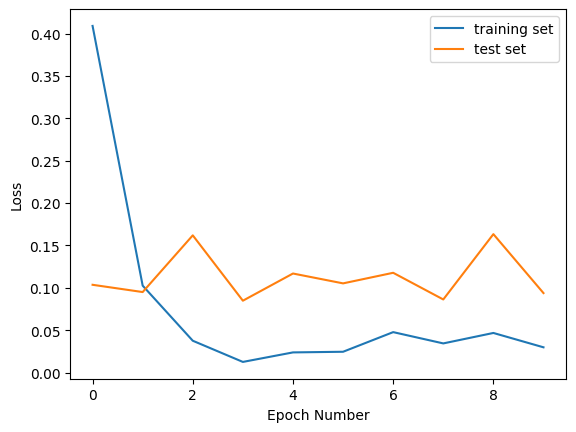

In [17]:
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.plot(history.history["loss"], label="training set")
plt.plot(history.history["val_loss"], label="test set")
plt.legend()

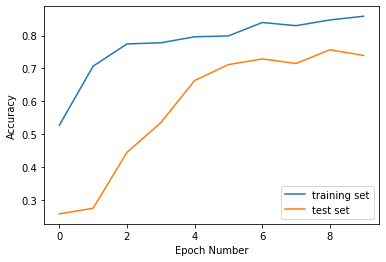

In [ ]:
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.plot(history.history["accuracy"], label="training set")
plt.plot(history.history["val_accuracy"], label="test set")
plt.legend()

In [ ]:
model.save("my_h5_model.h5")